In [0]:
from torchvision.datasets import utils
import torch.utils.data as data_utils
import torch
import os
import numpy as np
from torch import nn
from torch.nn.modules import upsampling
from torch.functional import F
from torch.optim import Adam


from torchvision.utils import save_image

# To do this assignment, I did look at this code for the general framework of how to implement VAE and I did copy some code from there:
https://github.com/pytorch/examples/blob/master/vae/main.py

In [4]:
# If a GPU is available, use it
# Pytorch uses an elegant way to keep the code device agnostic
if torch.cuda.is_available():
    device = torch.device("cuda")
    use_cuda = True
else:
    device = torch.device("cpu")
    use_cuda = False
    
print(device)

#torch.manual_seed(1) # I may need to fix other seeds

cuda


In [0]:
def get_data_loader(dataset_location, batch_size):
    URL = "http://www.cs.toronto.edu/~larocheh/public/datasets/binarized_mnist/"
    # start processing
    def lines_to_np_array(lines):
        return np.array([[int(i) for i in line.split()] for line in lines])
    splitdata = []
    for splitname in ["train", "valid", "test"]:
        filename = "binarized_mnist_%s.amat" % splitname
        filepath = os.path.join(dataset_location, filename)
        utils.download_url(URL + filename, dataset_location)
        with open(filepath) as f:
            lines = f.readlines()
        x = lines_to_np_array(lines).astype('float32')
        x = x.reshape(x.shape[0], 1, 28, 28)
        # pytorch data loader
        dataset = data_utils.TensorDataset(torch.from_numpy(x))
        print(splitname, len(dataset))
        dataset_loader = data_utils.DataLoader(x, batch_size=batch_size, shuffle=splitname == "train")
        splitdata.append(dataset_loader)
    return splitdata

In [6]:
batch_size = 64
train, valid, test = get_data_loader("binarized_mnist", 64)

Using downloaded and verified file: binarized_mnist/binarized_mnist_train.amat
train 50000
Using downloaded and verified file: binarized_mnist/binarized_mnist_valid.amat
valid 10000
Using downloaded and verified file: binarized_mnist/binarized_mnist_test.amat
test 10000


In [7]:
print(f"Your version of Pytorch is {torch.__version__}")

Your version of Pytorch is 1.0.1.post2


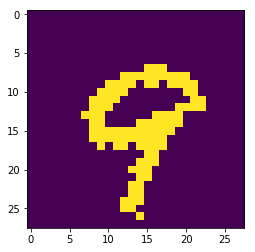

In [8]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
for x in train:
    plt.imshow(x[0, 0])
    break

In [9]:
print(train)

# Question 2.1: Train a VAE (10pts)

In [0]:
class Q2_VAE(nn.Module):
    def __init__(self):
        super(Q2_VAE, self).__init__()
        self.m = nn.ELU()
        self.conv_e1 = nn.Conv2d(1, 32, (3, 3))
        # ELU
        self.avg_pool_e1 = nn.AvgPool2d(kernel_size = 2, stride=2)
        self.conv_e2 = nn.Conv2d(32, 64, (3, 3))
        # ELU
        self.avg_pool_e2 = nn.AvgPool2d(kernel_size = 2, stride=2)
        self.conv_e3 = nn.Conv2d(64, 256, (5, 5))
        # ELU
        # Ne pas oublier de mettre en ligne les 256 pour faire une couche de MLP
        
        self.linear_mean = nn.Linear(256, 100, bias=True)
        self.linear_log_var = nn.Linear(256, 100, bias=True)
        
        self.linear_d1 = nn.Linear(100, 256, bias=True)
        # ELU
        # Je dois augmenter de deux dimensions(inverse de .view())
        self.conv_d1 = nn.Conv2d(256, 64, kernel_size=(5, 5), padding=(4, 4))
        # ELU
        #self.upsamp_d1 =nn.UpsamplingBilinear2d(scale_factor=2, mode='bilinear')
        self.conv_d2 = nn.Conv2d(64, 32, kernel_size=(3, 3), padding=(2, 2))
        # ELU
        #self.upsamp_d2 =nn.UpsamplingBilinear2d(scale_factor=2, mode='bilinear')
        self.conv_d3 = nn.Conv2d(32, 16, kernel_size=(3, 3), padding=(2, 2))
        # ELU
        self.conv_d4 = nn.Conv2d(16, 1, kernel_size=(3, 3), padding=(2, 2))
        

    def encode(self, x):
        x = self.conv_e1(x)
        x = self.m(x)
        x = self.avg_pool_e1(x)
        #print("Ici: ", x.shape)
        x = self.conv_e2(x)
        x = self.m(x)
        x = self.avg_pool_e2(x)
        x = self.conv_e3(x)
        x = self.m(x)
        x = x.view(-1, 256) 
        return self.linear_mean(x), self.linear_log_var(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar) + 10**(-7)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        out = self.linear_d1(z)
        out = self.m(out)
        out = out.view(-1, 256, 1, 1) # LFPR: J'ai change ca aussi
        out = self.conv_d1(out)
        out = self.m(out)
        #out = self.upsamp_d1(out)
        out = F.interpolate(out, scale_factor=2, mode='bilinear', align_corners=True)
        out = self.conv_d2(out)
        out = self.m(out)
        #out = self.upsamp_d2(out)
        out = F.interpolate(out, scale_factor=2, mode='bilinear', align_corners=True)
        out = self.conv_d3(out)
        out = self.m(out)
        return self.conv_d4(out)
        

    def forward(self, x):
        #mu, logvar = self.encode(x.view(-1, 784))
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [0]:
# Reconstruction + KL divergence losses summed over all elements and batch
# We return the negative of the ELBO for gradient descent
def loss_function(recon_x, x, mu, logvar):
    
    BCE=-torch.sum(F.binary_cross_entropy(torch.sigmoid(recon_x.view(-1, 784)\
                          ), x.view(-1, 784), reduction='none'),dim=1).mean()
    
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = 0.5*torch.sum(-1 - logvar + mu.pow(2) + logvar.exp(), dim = 1).mean()

    #return BCE + KLD
    return - (BCE - KLD)




def train_VAE(epoch,loader):
    model.train()
    train_loss = 0
    #for batch_idx, (data, _) in enumerate(loader):
    for batch_idx, data in enumerate(loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        #if batch_idx % 100 == 0:
        #    print('Train Epoch: {} [{}/{} ({:.0f}%)]\t average ELBO: {:.6f}'.format(
        #        epoch, batch_idx * len(data), len(loader.dataset),
        #        100. * batch_idx / len(loader),
        #        - batch_size * loss.item() / len(data)))
        
    average_ELBO = - train_loss * batch_size / len(loader.dataset)
    print('====> Epoch: {} Train set average ELBO: {:.4f}'.format(
          epoch, average_ELBO))
    return average_ELBO


def test_VAE(epoch, loader, state = "Validation"):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        #for i, (data, _) in enumerate(loader):
        for i, data in enumerate(loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            #if i == 0:
            #    n = min(data.size(0), 8)
            #    comparison = torch.cat([data[:n],
            #                            recon_batch.view(batch_size, 1, 28, 28)[:n]])
            #    save_image(comparison.cpu(),
            #                str(epoch) + '.png', nrow=n)
    
    test_loss /= (len(loader.dataset)/ batch_size)
    average_ELBO = - test_loss
    print('====> ' + state +' set average ELBO: {:.4f}'.format(average_ELBO))
    return average_ELBO


    

In [39]:
len(train.dataset)

50000

In [40]:
model = Q2_VAE()
model = model.to(device)

#optimizer = Adam(model.parameters(), lr=1e-3)
optimizer = Adam(model.parameters(), lr=3 * 10**(-4))


print(model)
print("\n\n# Parameters: ", sum([param.nelement() for param in model.parameters()]))

Q2_VAE(
  (m): ELU(alpha=1.0)
  (conv_e1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (avg_pool_e1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv_e2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (avg_pool_e2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv_e3): Conv2d(64, 256, kernel_size=(5, 5), stride=(1, 1))
  (linear_mean): Linear(in_features=256, out_features=100, bias=True)
  (linear_log_var): Linear(in_features=256, out_features=100, bias=True)
  (linear_d1): Linear(in_features=100, out_features=256, bias=True)
  (conv_d1): Conv2d(256, 64, kernel_size=(5, 5), stride=(1, 1), padding=(4, 4))
  (conv_d2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv_d3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv_d4): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
)


# Parameters:  938825


In [0]:
nb_epochs = 20
for epoch in range(1, nb_epochs + 1):
    train_VAE(epoch, train)
    test_VAE(epoch, valid)
    #with torch.no_grad():
    #    sample = torch.randn(64, 100).to(device)
    #    sample = model.decode(sample).cpu()
    #    save_image(sample.view(64, 1, 28, 28),
    #                str(epoch) + '.png')

====> Epoch: 1 Train set average ELBO: -183.5228
====> Validation set average ELBO: -138.4655
====> Epoch: 2 Train set average ELBO: -126.0273
====> Validation set average ELBO: -118.3038


KeyboardInterrupt: ignored

As can be seen in the previous cell, we obtain an ELBO of more than -95 on the validation set after 20 epochs, which is more than -96

In [0]:
 #a = torch.tensor([[-0.5,0.5,0.5],[0.5,0.5,0.5]], dtype=torch.float64)
 #b = torch.tensor([[1,1,1],[0,0,0]], dtype=torch.float64)
 #print(torch.sum(F.binary_cross_entropy(a, b, reduction='none')+0,dim = 1))
 #
 #print(F.binary_cross_entropy(a, b) * 6)

In [0]:
a = torch.tensor([[0.5,0.5,0.5],[0.5,0.5,0.5]], dtype=torch.float64)
b = torch.tensor([[1,1,1],[0,0,0]], dtype=torch.float64)
print(torch.sum(F.binary_cross_entropy(a, b, reduction='none')+0,dim = 1))
 
print(F.binary_cross_entropy(a, b) * 6)

tensor([2.0794, 2.0794], dtype=torch.float64)
tensor(4.1589, dtype=torch.float64)


# Question 2.2: Evaluating log-likelihood with Variational Autoencoders (20 pts)

**Question 2.2.1**

In [0]:
def copy_tensor_K_times(tensor, K):
  return torch.stack([tensor for _ in range(K)])

In [0]:
def reconstruction(multi_x,z_x,model):
  recon_x = model.decode(z_x)
  return - torch.sum(F.binary_cross_entropy(torch.sigmoid(recon_x.view(-1, 784)), multi_x.view(-1, 784), reduction='none'),dim=1)

In [0]:
def log_gaussian_standard(z):
  return torch.sum(- z**2/2, dim = 1) # pas d'autres termes car sigma = 1

In [0]:
def log_gaussian_density(z_x, multi_x, model):
  mu, logvar = model.encode(multi_x)
  #CONTINUER ICI
  return torch.sum(-(z_x - mu)**2/(2*torch.exp(logvar)) - torch.log(torch.exp(0.5*logvar) + 10**(-7)), dim = 1)

In [0]:
def importance_sampling(model, X, Z):
  model.eval()
  log_probs = []
  for pos, x in enumerate(X):
    z_x = Z[pos]
    multi_x = copy_tensor_K_times(x, Z.shape[1]) 
    log_p_x_z = reconstruction(multi_x,z_x,model)
    log_p_z = log_gaussian_standard(z_x)
    log_q_z_x = log_gaussian_density(z_x, multi_x, model)
    #print("log_p_x_z ", log_p_x_z)
    #print("log_p_z ", log_p_z)
    #print("log_q_z_x ", log_q_z_x)
    
    w =log_p_x_z + log_p_z - log_q_z_x
    #print(w)
    m = torch.max(w)
    #print("max",m)
    #print(w-m)
    value = - torch.log(torch.tensor(Z.shape[1],dtype=torch.float64)) + m + torch.log(torch.sum(torch.exp(w-m)))
    #print(value)
    log_probs.append(value)
  return log_probs

**Question 2.2.2**

In [0]:
def all_log_X(model,loader,K):
  model.eval()
  les_log_probs = []
  with torch.no_grad():
    for batch_idx, data in enumerate(loader):
      data = data.to(device)
      #print(data.shape)
      for x in data:
        multi_x = copy_tensor_K_times(x, K)
        mu, log_var = model.encode(multi_x)
        z = model.reparameterize(mu, log_var)
        #print(x[None, : ,:, :].shape, z.shape)
        les_log_probs += importance_sampling(model, x[None, : ,:, :], z[None, : ,:])
  return les_log_probs

In [0]:
#torch.stack(all_log_X(model,valid,200)).mean()

In [0]:
#torch.stack(all_log_X(model,test,200)).mean()

In [35]:
a = torch.tensor([[0.5,0.5,0.5],[0.5,0.5,0.5]], dtype=torch.float64)
b = torch.tensor([[1,1,1],[0,0,0]], dtype=torch.float64)
print(torch.sum(F.binary_cross_entropy(a, b, reduction='none')+0,dim = 1))
 
print(F.binary_cross_entropy(a, b) * 6)

tensor([2.0794, 2.0794], dtype=torch.float64)
tensor(4.1589, dtype=torch.float64)


In [63]:
model = Q2_VAE()
model = model.to(device)

#optimizer = Adam(model.parameters(), lr=1e-3)
optimizer = Adam(model.parameters(), lr=3 * 10**(-4))


print(model)
print("\n\n# Parameters: ", sum([param.nelement() for param in model.parameters()]))

Q2_VAE(
  (m): ELU(alpha=1.0)
  (conv_e1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (avg_pool_e1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv_e2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (avg_pool_e2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv_e3): Conv2d(64, 256, kernel_size=(5, 5), stride=(1, 1))
  (linear_mean): Linear(in_features=256, out_features=100, bias=True)
  (linear_log_var): Linear(in_features=256, out_features=100, bias=True)
  (linear_d1): Linear(in_features=100, out_features=256, bias=True)
  (conv_d1): Conv2d(256, 64, kernel_size=(5, 5), stride=(1, 1), padding=(4, 4))
  (conv_d2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv_d3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv_d4): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
)


# Parameters:  938825


In [64]:
nb_epochs = 20
valid_ELBOs = []
test_ELBOs = []
log_likeli_est_valid = []
log_likeli_est_test = []
for epoch in range(1, nb_epochs + 1):
    train_VAE(epoch, train)
    
    valid_ELBOs.append(test_VAE(epoch, valid, "Validation"))
    v_log_like_est= torch.stack(all_log_X(model,valid,200)).mean()
    print("valid log likelihood estimate: ", v_log_like_est.item())
    log_likeli_est_valid.append(v_log_like_est)
    
    test_ELBOs.append(test_VAE(epoch, test, "Test"))
    t_log_like_est= torch.stack(all_log_X(model,test,200)).mean()
    print("test log likelihood estimate: ", t_log_like_est.item())
    log_likeli_est_test.append(t_log_like_est)
    
    
    #with torch.no_grad():
    #    sample = torch.randn(64, 100).to(device)
    #    sample = model.decode(sample).cpu()
    #    save_image(sample.view(64, 1, 28, 28),
    #                str(epoch) + '.png')

====> Epoch: 1 Train set average ELBO: -188.9227
====> Validation set average ELBO: -143.5680
valid log likelihood estimate:  -130.0609349931279
====> Test set average ELBO: -142.0968
test log likelihood estimate:  -128.6616628875085
====> Epoch: 2 Train set average ELBO: -128.4978
====> Validation set average ELBO: -119.9688
valid log likelihood estimate:  -109.41859173938539
====> Test set average ELBO: -118.4249
test log likelihood estimate:  -108.1382456149142
====> Epoch: 3 Train set average ELBO: -113.9364
====> Validation set average ELBO: -110.5928
valid log likelihood estimate:  -102.07113832260337
====> Test set average ELBO: -109.3501
test log likelihood estimate:  -100.87480231510914
====> Epoch: 4 Train set average ELBO: -107.7312
====> Validation set average ELBO: -106.7288
valid log likelihood estimate:  -98.65481817337222
====> Test set average ELBO: -105.4131
test log likelihood estimate:  -97.5641586450368
====> Epoch: 5 Train set average ELBO: -104.5327
====> Validat

In [53]:
a.data

tensor([[0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000]], dtype=torch.float64)

In [61]:
a[0,0].item()

0.5

In [75]:
"valid_ELBOs: ", valid_ELBOs

('valid_ELBOs: ',
 [-143.5680021484375,
  -119.968783984375,
  -110.59284765625,
  -106.72881821289063,
  -104.411356640625,
  -102.55339965820312,
  -101.10665673828125,
  -100.37588842773438,
  -99.21325922851562,
  -98.6468490234375,
  -98.33601171875,
  -97.42303930664062,
  -97.13451640625,
  -96.2900638671875,
  -96.09679956054687,
  -95.76553125,
  -95.3789501953125,
  -95.3980119140625,
  -95.1512998046875,
  -94.86121572265625])

In [76]:
"test_ELBOs: ", test_ELBOs

('test_ELBOs: ',
 [-142.09683178710938,
  -118.42489033203125,
  -109.35011579589843,
  -105.41313127441406,
  -103.250404296875,
  -101.4388796875,
  -100.09616027832031,
  -99.40500810546875,
  -98.22678623046875,
  -97.62643352050782,
  -97.39824763183594,
  -96.52913178710938,
  -96.38504799804687,
  -95.44707783203125,
  -95.27927751464844,
  -94.89763935546875,
  -94.61111638183594,
  -94.61529077148438,
  -94.2757079345703,
  -93.92423166503906])

In [77]:
"log_likeli_est_valid: ", list(torch.stack(log_likeli_est_valid).numpy())

('log_likeli_est_valid: ',
 [-130.0609349931279,
  -109.41859173938539,
  -102.07113832260337,
  -98.65481817337222,
  -96.80253218677353,
  -95.13247288953673,
  -94.04426626883975,
  -93.13876938823601,
  -92.6718794368733,
  -91.96068681231269,
  -91.58882638788833,
  -91.04455395064801,
  -90.65514751522767,
  -90.30716029435357,
  -89.99670131567714,
  -89.75424664306708,
  -89.46230488789408,
  -89.25945385708421,
  -89.1138848561111,
  -88.88066920154166])

In [78]:
"log_likeli_est_test: ", list(torch.stack(log_likeli_est_test).numpy())

('log_likeli_est_test: ',
 [-128.6616628875085,
  -108.1382456149142,
  -100.87480231510914,
  -97.5641586450368,
  -95.79352636514403,
  -94.1708466340263,
  -93.08986120069062,
  -92.25919538217249,
  -91.80895926522676,
  -91.07897093740496,
  -90.77954774862854,
  -90.23922879053052,
  -89.88584279568391,
  -89.56262104035154,
  -89.20438588462311,
  -89.05170392044644,
  -88.72597433028025,
  -88.53959239593958,
  -88.40012316035137,
  -88.2041653995502])

In [67]:
-143.5680021484375

-143.5680021484375